In [2]:
import math
import io
import shutil
import os
import sys
from os import path
import json

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
df = pd.read_csv(path.join('dataset', 'F:\INTRUSION DETECTION DATASET\EVSE-B-HPC-Kernel-Events-processed.csv'))
df

,irq_softirq_exit,irq_softirq_entry,irq_softirq_raise,kmem_kmem_cache_free,kmem_kmem_cache_alloc,net_netif_rx,net_netif_rx_ni_exit,net_netif_rx_ni_entry,rpm_rpm_usage,rpm_rpm_resume,...,Scenario_DoS,Scenario_Recon,Label_attack,Label_benign,interface_any,interface_iso15118,interface_iso15118,interface_none,interface_ocpp,isDoS
0,5808,5808,5826,3976,4016,0,0,0,4277,4369,...,False,False,True,False,True,False,False,False,False,False
1,4791,4791,4808,12217,13581,0,0,0,1355,1391,...,False,False,True,False,True,False,False,False,False,False
2,6635,6635,6667,16222,16487,0,0,0,2683,2719,...,False,False,True,False,True,False,False,False,False,False
3,9165,9165,9228,15833,17867,0,0,0,4934,4988,...,False,False,True,False,True,False,False,False,False,False
4,8405,8405,8431,16182,15720,0,0,0,4736,4778,...,False,False,True,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6161,95032,95032,95043,109798,109887,44337,44335,44335,80240,80266,...,True,False,True,False,False,False,False,False,True,True
6162,96744,96744,96779,98202,98220,37797,37795,37795,69827,69873,...,True,False,True,False,False,False,False,False,True,True
6163,99936,99935,99947,105024,104998,41208,41208,41208,75511,75531,...,True,False,True,False,False,False,False,False,True,True
6164,96575,96576,96590,99527,99583,38825,38825,38825,71057,71074,...,True,False,True,False,False,False,False,False,True,True


In [4]:
# min-max normalization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df)
df_normalized = pd.DataFrame(normalized_data, columns=df.columns)
df_normalized

,irq_softirq_exit,irq_softirq_entry,irq_softirq_raise,kmem_kmem_cache_free,kmem_kmem_cache_alloc,net_netif_rx,net_netif_rx_ni_exit,net_netif_rx_ni_entry,rpm_rpm_usage,rpm_rpm_resume,...,Scenario_DoS,Scenario_Recon,Label_attack,Label_benign,interface_any,interface_iso15118,interface_iso15118,interface_none,interface_ocpp,isDoS
0,0.047937,0.047935,0.048078,0.010061,0.010228,0.000000,0.000000,0.000000,0.042511,0.043414,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.039543,0.039541,0.039677,0.030916,0.034589,0.000000,0.000000,0.000000,0.013468,0.013822,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.054762,0.054760,0.055019,0.041051,0.041990,0.000000,0.000000,0.000000,0.026667,0.027018,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.075644,0.075641,0.076153,0.040066,0.045505,0.000000,0.000000,0.000000,0.049041,0.049565,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.069371,0.069369,0.069576,0.040949,0.040037,0.000000,0.000000,0.000000,0.047073,0.047478,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6161,0.784351,0.784325,0.784332,0.277850,0.279868,0.706026,0.706005,0.705994,0.797535,0.797587,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
6162,0.798481,0.798455,0.798658,0.248506,0.250153,0.601882,0.601860,0.601850,0.694036,0.694314,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
6163,0.824827,0.824791,0.824802,0.265769,0.267416,0.656199,0.656210,0.656199,0.750532,0.750537,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
6164,0.797086,0.797068,0.797098,0.251859,0.253625,0.618252,0.618262,0.618252,0.706262,0.706248,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [5]:
# data splitting: training and testing
from sklearn.model_selection import train_test_split

# Separate features and labels
# X = df_normalized.iloc[:, :-1].values  # All columns except the last one
X = df_normalized.iloc[:, :10].values  # All columns except the last one
y = df_normalized.iloc[:, -1].values   # The last column (label)

# Split dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device).unsqueeze(1)

# If the labels are for classification, ensure they're of `long` dtype
# y_train_tensor = y_train_tensor.long()
# y_test_tensor = y_test_tensor.long()

In [6]:
print(X_train_tensor.shape)
print(X_test_tensor.shape)
print(y_train_tensor.shape)
print(y_test_tensor.shape)

torch.Size([4932, 1, 10])
torch.Size([1234, 1, 10])
torch.Size([4932, 1])
torch.Size([1234, 1])


In [10]:
class TransformerBinaryClassifier(nn.Module):
    def __init__(self, d_model):
        super(TransformerBinaryClassifier, self).__init__()
        self.input_layer = nn.Linear(d_model, 64)   # Fix: input is feature size
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=64, nhead=2, dim_feedforward=128, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.fc = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(1)  # add sequence dimension
        x = self.input_layer(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)  # global average pooling
        return self.fc(x)


In [11]:
print(X_train_tensor.shape)
print(X_test_tensor.shape)


torch.Size([4932, 10])
torch.Size([1234, 10])


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np
import os

# ======================
#  Define WCGAN Components
# ======================

# Generator (Conditional)
class WCGAN_Generator(nn.Module):
    def __init__(self, noise_dim, condition_dim, output_dim):
        super(WCGAN_Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim + condition_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, output_dim),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        x = torch.cat((noise, labels), dim=1)
        return self.model(x)


# Critic (Discriminator)
class WCGAN_Critic(nn.Module):
    def __init__(self, input_dim, condition_dim):
        super(WCGAN_Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim + condition_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1)
        )

    def forward(self, x, labels):
        # Flatten if input is 3D
        if x.dim() > 2:
            x = x.view(x.size(0), -1)  # (batch_size, flattened_features)
        d_in = torch.cat((x, labels), dim=1)
        return self.model(d_in)



# Wasserstein Loss
def wasserstein_loss(y_pred, y_true):
    return -torch.mean(y_pred * y_true)


# ======================
#  Train WCGAN
# ======================

def train_wcgan(X_train_tensor, y_train_tensor, noise_dim=32, n_epochs=100, batch_size=128, lr=1e-4, clip_value=0.01, n_critic=5):
    device = X_train_tensor.device
    input_dim = X_train_tensor.shape[1]
    condition_dim = 1  # Label (binary)
    
    generator = WCGAN_Generator(noise_dim, condition_dim, input_dim).to(device)
    critic = WCGAN_Critic(input_dim, condition_dim).to(device)

    optimizer_G = optim.RMSprop(generator.parameters(), lr=lr)
    optimizer_C = optim.RMSprop(critic.parameters(), lr=lr)

    dataset = TensorDataset(X_train_tensor, y_train_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(n_epochs):
        for i, (real_samples, labels) in enumerate(loader):
            real_samples, labels = real_samples.to(device), labels.to(device)

            # ---------------------
            # Train Critic
            # ---------------------
            for _ in range(n_critic):
                optimizer_C.zero_grad()

                # Real loss
                real_validity = critic(real_samples, labels)
                real_loss = torch.mean(real_validity)

                # Fake samples
                noise = torch.randn(real_samples.size(0), noise_dim, device=device)
                fake_samples = generator(noise, labels)
                fake_validity = critic(fake_samples.detach(), labels)
                fake_loss = torch.mean(fake_validity)

                # Wasserstein loss
                loss_C = -(real_loss - fake_loss)
                loss_C.backward()
                optimizer_C.step()

                # Weight clipping
                for p in critic.parameters():
                    p.data.clamp_(-clip_value, clip_value)

            # ---------------------
            # Train Generator
            # ---------------------
            optimizer_G.zero_grad()
            noise = torch.randn(real_samples.size(0), noise_dim, device=device)
            fake_samples = generator(noise, labels)
            fake_validity = critic(fake_samples, labels)
            loss_G = -torch.mean(fake_validity)
            loss_G.backward()
            optimizer_G.step()

        if (epoch + 1) % 10 == 0:
            print(f"[WCGAN Epoch {epoch+1}/{n_epochs}]  Critic Loss: {loss_C:.4f}  Generator Loss: {loss_G:.4f}")

    return generator


# ======================
#  Generate Synthetic Data using WCGAN
# ======================

def generate_synthetic_data(generator, n_samples, noise_dim=32, label_value=1, device='cpu'):
    labels = torch.full((n_samples, 1), label_value, device=device)
    noise = torch.randn(n_samples, noise_dim, device=device)
    synthetic_data = generator(noise, labels)
    return synthetic_data.detach(), labels


# ======================
# Train Transformer Model (your existing code)
# ======================

# Example parameters
d_model = 10
nhead = 2
num_layers = 2
batch_size = 512
epochs = 100
patience = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerBinaryClassifier(d_model=X_train_tensor.shape[1]).to(device)

# Define your TransformerBinaryClassifier (already built)
# model = TransformerBinaryClassifier(d_model, nhead, num_layers).to(device)

X_train_tensor = X_train_tensor.view(X_train_tensor.size(0), -1)
X_test_tensor = X_test_tensor.view(X_test_tensor.size(0), -1)


# Train WCGAN first
generator = train_wcgan(X_train_tensor, y_train_tensor, n_epochs=100)

# Generate synthetic samples
synthetic_X, synthetic_y = generate_synthetic_data(generator, n_samples=2000, device=device)

# Combine with real data
X_augmented = torch.cat((X_train_tensor, synthetic_X), dim=0)
y_augmented = torch.cat((y_train_tensor, synthetic_y), dim=0)

# DataLoader for augmented dataset
train_dataset = TensorDataset(X_augmented, y_augmented)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Loss and optimizer for Transformer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Early stopping setup
best_val_loss = float('inf')
epochs_no_improve = 0
train_losses = []
val_losses = []

# ======================
#  Train Transformer on Augmented Data
# ======================

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)  # Works now!
        loss = criterion(outputs, y_batch)

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            preds = (outputs > 0.5).long()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    val_loss /= len(test_loader)
    val_losses.append(val_loss)

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, zero_division=0)
    rec = recall_score(all_labels, all_preds, zero_division=0)

    print(f"Epoch {epoch+1}/{epochs}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Acc={acc:.4f}, Prec={prec:.4f}, Recall={rec:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model_augmented.pth")
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print("Early stopping triggered.")
        break

print("✅ Training complete with WCGAN augmentation.")


[WCGAN Epoch 10/100]  Critic Loss: -0.0014  Generator Loss: -0.0083
[WCGAN Epoch 20/100]  Critic Loss: -0.0021  Generator Loss: -0.0072
[WCGAN Epoch 30/100]  Critic Loss: -0.0017  Generator Loss: -0.0073
[WCGAN Epoch 40/100]  Critic Loss: -0.0011  Generator Loss: -0.0078
[WCGAN Epoch 50/100]  Critic Loss: -0.0007  Generator Loss: -0.0086
[WCGAN Epoch 60/100]  Critic Loss: -0.0008  Generator Loss: -0.0072
[WCGAN Epoch 70/100]  Critic Loss: -0.0008  Generator Loss: -0.0084
[WCGAN Epoch 80/100]  Critic Loss: -0.0010  Generator Loss: -0.0074
[WCGAN Epoch 90/100]  Critic Loss: -0.0008  Generator Loss: -0.0069
[WCGAN Epoch 100/100]  Critic Loss: -0.0006  Generator Loss: -0.0083
Epoch 1/100: Train Loss=0.6636, Val Loss=0.5821, Acc=0.9887, Prec=0.9415, Recall=0.9758
Epoch 2/100: Train Loss=0.6084, Val Loss=0.4932, Acc=0.9903, Prec=0.9422, Recall=0.9879
Epoch 3/100: Train Loss=0.5621, Val Loss=0.4056, Acc=0.9903, Prec=0.9422, Recall=0.9879
Epoch 4/100: Train Loss=0.5163, Val Loss=0.3359, Acc=0.

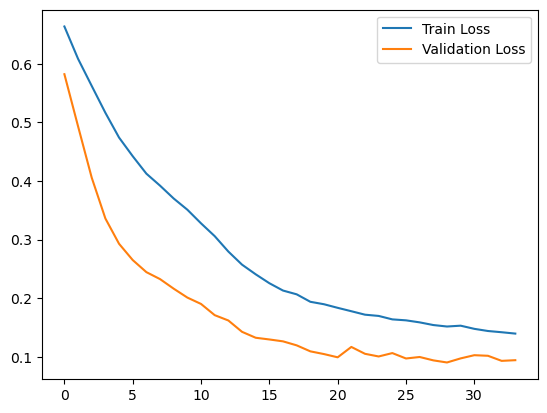

In [13]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()


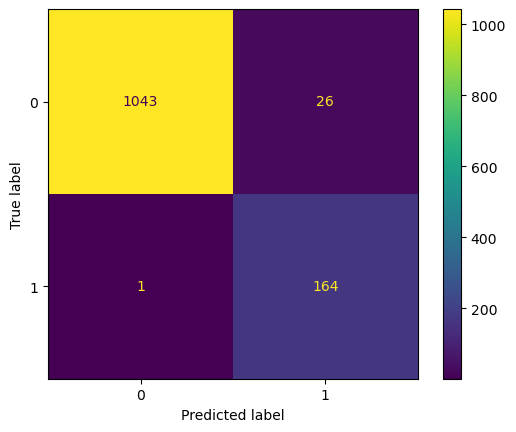

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(all_labels, all_preds)
ConfusionMatrixDisplay(cm).plot()
plt.show()


In [15]:
torch.save(model.state_dict(), "best_transformer_wcgan_ev.pth")


In [16]:
import torch
import torch.nn as nn

class CNN_LSTM_IDS(nn.Module):
    def __init__(self, input_dim, conv_channels=32, lstm_hidden=64, lstm_layers=1, dropout=0.2):
        super(CNN_LSTM_IDS, self).__init__()
        # Expect input: (batch, seq_len, features). If seq_len==1, treat features as 1D series.
        # We'll interpret features as a 1D "signal" for Conv1d by reshaping.
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=conv_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(conv_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveMaxPool1d(output_size=8)  # reduce to fixed length
        
        # LSTM works over time steps; we'll treat conv output as seq_len for LSTM
        self.lstm = nn.LSTM(input_size=conv_channels, hidden_size=lstm_hidden, num_layers=lstm_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Sequential(
            nn.Linear(lstm_hidden*2, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        # Accept x shape: (batch, features) or (batch, seq_len, features)
        if x.dim() == 2:
            # (batch, features) -> (batch, 1, features)
            x = x.unsqueeze(1)
        # if x is (batch, seq_len, features) we may collapse seq_len with features or handle differently.
        # Here we flatten seq_len dimension into features axis if needed:
        if x.dim() == 3 and x.size(1) > 1:
            # flatten seq_len into feature axis: (batch, 1, seq_len*features)
            b, s, f = x.size()
            x = x.reshape(b, 1, s*f)
        # Now shape (batch, 1, L)
        x = self.conv1(x)           # (batch, conv_channels, L)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)            # (batch, conv_channels, 8)
        # prepare for LSTM: we want (batch, seq_len, features) -> treat 8 as seq_len
        x = x.permute(0, 2, 1)      # (batch, 8, conv_channels)
        out, _ = self.lstm(x)       # (batch, 8, 2*lstm_hidden)
        out = out.mean(dim=1)       # (batch, 2*lstm_hidden)
        out = self.fc(out)          # (batch, 1)
        return out
model = CNN_LSTM_IDS(input_dim=X_train_tensor.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# use DataLoader on X_train_tensor, y_train_tensor (2D tensors)


In [45]:
input_dim = X_train.shape[1]
print("Input dimension:", input_dim)


Input dimension: 10


In [32]:
!pip install torchvision


Defaulting to user installation because normal site-packages is not writeable
  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
   ---------------------------------------- 0.0/4.0 MB ? eta -:--:--
   ------------------- -------------------- 1.9/4.0 MB 41.2 MB/s eta 0:00:01
   ---------------------------------------  4.0/4.0 MB 42.7 MB/s eta 0:00:01
   ---------------------------------------- 4.0/4.0 MB 32.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/109.3 MB ? eta -:--:--
    --------------------------------------- 2.3/109.3 MB 48.1 MB/s eta 0:00:03
   - -------------------------------------- 4.3/109.3 MB 55.4 MB/s eta 0:00:02
   -- ------------------------------------- 6.8/109.3 MB 54.1 MB/s eta 0:00:02
   -- ------------------------------------- 7.5/109.3 MB 47.6 MB/s eta 0:00:03
   -- ------------------------------------- 7.6/109.3 MB 34.6 MB/s eta 0:00:03
   -- -------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  You can safely remove it manually.


In [39]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


Note: you may need to restart the kernel to use updated packages.Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu121
  Using cached https://download.pytorch.org/whl/cu121/torch-2.5.1%2Bcu121-cp311-cp311-win_amd64.whl (2449.4 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchvision-0.20.1%2Bcu121-cp311-cp311-win_amd64.whl (6.1 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchaudio-2.5.1%2Bcu121-cp311-cp311-win_amd64.whl (4.1 MB)



  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [1]:
import torch, torchvision
print("Torch:", torch.__version__)
print("TorchVision:", torchvision.__version__)
print("CUDA available:", torch.cuda.is_available())


Torch: 2.5.1+cu121
TorchVision: 0.20.1+cu121
CUDA available: False


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
import torchvision.transforms as transforms
from PIL import Image

def window_to_image(window):
    """
    window: 1D numpy array of length L (features)
    return: torch tensor shape (C,H,W) normalized [0,1]
    """
    # reshape to near-square matrix: choose H = int(sqrt(L)) or a fixed H
    L = window.shape[0]
    H = int(np.ceil(np.sqrt(L)))
    # pad
    pad = H*H - L
    arr = np.pad(window, (0, pad), 'constant', constant_values=(0,))
    mat = arr.reshape(H, H)
    # normalize mat to 0-255 for image
    mat = (mat - mat.min()) / (mat.max()-mat.min() + 1e-8)
    mat = (mat * 255).astype(np.uint8)
    img = Image.fromarray(mat)
    # convert to 3-channel RGB
    img = img.convert("RGB").resize((64,64))
    tf = transforms.Compose([
        transforms.ToTensor()  # -> [0,1] float tensor (C,H,W)
    ])
    return tf(img)

# Example: create dataset of images (torch tensors) from X_train numpy
X_train_np = X_train_tensor.cpu().numpy()
img_tensors = [window_to_image(x) for x in X_train_np]
X_img = torch.stack(img_tensors)  # (N, C, H, W)


class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64*16*16, 128), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128,1), nn.Sigmoid()
        )
    def forward(self,x):
        return self.net(x)


In [36]:
def predict_ensemble(models, scalers, raw_vector):
    """
    models: dict {'transformer': tmodel, 'cnn_lstm': m1, 'img_cnn': m2}
    scalers: scaler used for normalization
    raw_vector: 1d array scaled raw
    """
    # prepare inputs
    x = np.array(raw_vector).reshape(1, -1)
    x_scaled = scalers.transform(x)  # keep scaler used for training
    x_tensor = torch.tensor(x_scaled, dtype=torch.float32).to(device)
    # transformer expects (batch,features) -> works
    p1 = models['transformer'](x_tensor).detach().cpu().numpy().item()
    p2 = models['cnn_lstm'](x_tensor).detach().cpu().numpy().item()
    # image
    img_t = window_to_image(x_scaled.flatten()).unsqueeze(0).to(device)
    p3 = models['img_cnn'](img_t).detach().cpu().numpy().item()
    # average probabilities
    p_mean = (p1 + p2 + p3) / 3.0
    label = "attack" if p_mean >= 0.5 else "normal"
    return {"prob": p_mean, "label": label, "components": [p1,p2,p3]}


In [46]:
transformer_model = TransformerBinaryClassifier(d_model=10)
cnn_lstm_model = CNN_LSTM_IDS(input_dim=10)
img_cnn_model = SimpleCNN()

torch.save(transformer_model.state_dict(), r"F:\INTRUSION DETECTION DATASET\transformer_model.pth")
torch.save(cnn_lstm_model.state_dict(), r"F:\INTRUSION DETECTION DATASET\cnn_lstm_model.pth")
torch.save(img_cnn_model.state_dict(), r"F:\INTRUSION DETECTION DATASET\img_cnn_model.pth")


In [49]:
import joblib

# Example during preprocessing
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)  # or fit_transform

# Save it
joblib.dump(scaler, r"F:\INTRUSION DETECTION DATASET\scaler.pkl")
print("Scaler saved successfully!")


Scaler saved successfully!
